# Neuraal netwerk oefening: Nintendo games

In deze opgave gaan we een aantal eenvoudige neurale netwerken maken om de basisfunctionaliteit in te oefenen van Torch en Keras. Hierbij focussen we vooral op de processing stappen, het opstellen van de netwerkarchitectuur en de trainingsstap.
Het is hierbij niet noodzakelijk om op zoek te gaan naar de beste architectuur.

**Dien de opgave in door het te pushen naar de main branch op github en vergeet niet op de vragen te beantwoorden. Laat je output staan om eenvoudiger je resultaten te kunnen verifieren. Vergeet ook de vragen niet te beantwoorden**

## Downloaden en inladen data

Schrijf in onderstaande cell alle uit te voeren imports die nodig zijn doorheen deze notebook.

In [1]:
# Schrijf alle imports in deze blok
import pandas as pd

In [ ]:
!pip install kagglehub

In deze opgave maken we gebruik van een dataset over Nintendo games.
We gaan deze dataset gebruiken om de gebrukersscore te voorspellen die een bepaald spel gaat behalen.

Maak gebruik van de tensorflow get_file om de volgende file te downloaden:
* https://www.kaggle.com/datasets/joebeachcapital/nintendo-games

Dit is een dataset van kaggle dus gebruik de opendatasets library zoals gezien in data science

In [2]:
# downloaden datasets
import kagglehub

path = kagglehub.dataset_download('joebeachcapital/nintendo-games') # het path is waar de dataset gedownload is

df = pd.read_csv(f"{path}/NintendoGames.csv")

Lees deze datasets in (met behulp van panda) en als dataframe.
Print de eerste 5 rijen uit.

**Welke kolommen zijn in deze dataset de features en welke de targets/labels? Welke kolommen zou je niet gebruiken en waarom?**
Maak lijsten aan voor de namen van de feature-kolommen en label kolom.

Antwoord: ...

In [3]:
display(df.head())
df.info()

,meta_score,title,platform,date,user_score,link,esrb_rating,developers,genres
0,NaN,Super Mario RPG,Switch,"Nov 17, 2023",NaN,/game/switch/super-mario-rpg,E,['Nintendo'],"['Role-Playing', 'Japanese-Style']"
1,NaN,WarioWare: Move It!,Switch,"Nov 3, 2023",NaN,/game/switch/warioware-move-it!,RP,['Intelligent Systems'],"['Miscellaneous', 'Party / Minigame']"
2,NaN,Super Mario Bros. Wonder,Switch,"Oct 20, 2023",NaN,/game/switch/super-mario-bros-wonder,E,['Nintendo'],"['Action', 'Platformer', '2D']"
3,NaN,Detective Pikachu Returns,Switch,"Oct 6, 2023",NaN,/game/switch/detective-pikachu-returns,NaN,['Creatures Inc.'],"['Adventure', '3D', 'Third-Person']"
4,NaN,Fae Farm,Switch,"Sep 8, 2023",NaN,/game/switch/fae-farm,E10+,['Phoenix Labs'],"['Simulation', 'Virtual', 'Virtual Life']"


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1094 entries, 0 to 1093
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   meta_score   709 non-null    float64
 1   title        1094 non-null   object 
 2   platform     1094 non-null   object 
 3   date         1094 non-null   object 
 4   user_score   856 non-null    float64
 5   link         1094 non-null   object 
 6   esrb_rating  972 non-null    object 
 7   developers   1091 non-null   object 
 8   genres       1094 non-null   object 
dtypes: float64(2), object(7)
memory usage: 77.0+ KB


## Exploratory Data Analysis

Bereken voor de dataset de volgende statistieken met behulp van pandas:
* Hoeveel platformen zijn er aanwezig in de dataset
* Hoeveel games hebben geen user-score? Drop deze rijen ook.
* Maak een figuur om te tonen hoeveel games er ontwikkeld zijn voor elk platform.
* Hoeveel null waarden zijn er per kolom? Vul de numerieke kolommen aan met 0 en de categorieke kolommen met 'unknown'.
* Is de genres en developer kolom een string of een lijst? Zijn ze beide hetzelfde type? Hoe heb je dit gecontroleerd? Pas de kolommen met de apply-functie aan zodat beide kolommen een tekstveld zijn gesplitst door het ',' symbool.
* Hoeveel unieke developers zijn er die nintendo games maken? Wat zijn de 5 developers die aan het meeste games gewerkt hebben? Maak hiervoor een figuur.


**Antwoord vraag 5:**

In [4]:
# Vraag 1
df.platform.nunique()

10

In [5]:
# Vraag 2
nans = df.isna().user_score
print('aantal nuns', nans.sum())
df2 = df[~nans]
print('aantal rijen overgebleven', len(df2))

aantal nuns 238
aantal rijen overgebleven 856


<Axes: xlabel='platform'>

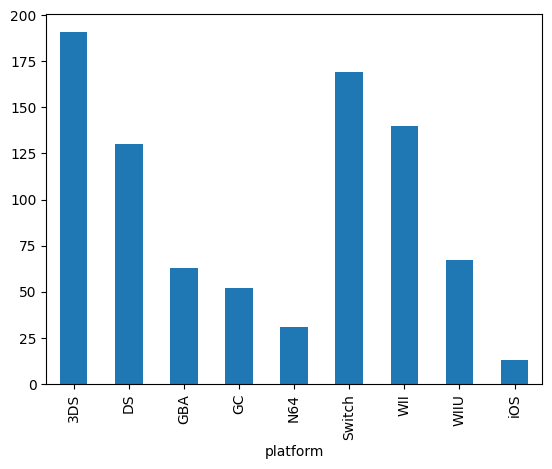

In [6]:
# Vraag 3
df2.groupby('platform').size().plot.bar()

In [7]:
# Vraag 4
df2.isna().sum()
df3 = df2.fillna({'meta_score': 0, 'esrb_rating': 'unknown'})

In [8]:
# Vraag 5
print(df3.genres.iloc[0], type(df3.genres.iloc[0]))
print(df3.developers.iloc[0], type(df3.developers.iloc[0]))

df4 = df3.copy()
df4.genres = df3.genres.str.strip("[]").str.replace("'", "", regex=False)
df4.developers = df3.developers.str.strip("[]").str.replace("'", "", regex=False)

['Strategy', 'Real-Time', 'General'] <class 'str'>
['Nintendo'] <class 'str'>


aantal unieke developers 181


<Axes: xlabel='developers'>

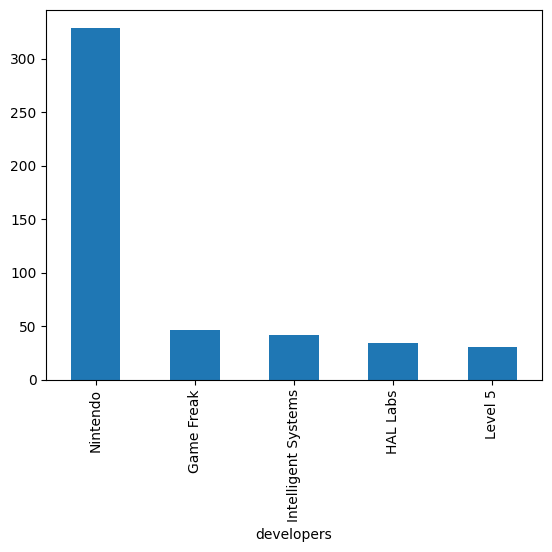

In [9]:
# Vraag 6
tmp = df4.developers.str.split(', ').explode()
print('aantal unieke developers', tmp.nunique())

tmp.value_counts().head(5).plot.bar()

## Preprocessing

Voer nu de volgende stappen uit om de beschikbare data zo bruikbaar mogeljk te maken. **Gebruik de user_score als target.**
* Splits de dataset in training en testdata. Gebruik 10% van de data als testdata. Tip: bekijk de sample functie in pandas. Zorg ervoor dat rijen met ontbrekende waarden niet gebruikt worden.
* Maak een trainings- en testdataset aan gebruik makende van de Dataset klasse van PyTorch. Zorg er hierbij voor dat de volgende features gebruikt worden: platform, meta_score, esrb_rating, developers, genres. Natuurlijk moet het target ook meegegeven worden bij het aanmaken van de dataset. Zorg ervoor dat de nodige preprocessing stappen uitgevoerd worden:
    * Maak nu de nodige preprocessing stappen aan voor de types data:
        * numeriek -> normalisatie
        * categoriek -> one-hot encoding
        * tekst -> multi-hot encoding
* Maak daarna Dataloaders aan en zorg er hierbij voor dat alle elementen geshuffeld worden, maak daarna batches van 4 elementen.

**Vraag: Je hebt hiervoor het aantal unieke developers berekend. Kan je uit de figuur afleiden of dit aantal klopt? Hoe doe je dit? Verwijs hierbij naar de gemaakte figuur.**

**Antwoord:**

In [10]:
df4.columns

Index(['meta_score', 'title', 'platform', 'date', 'user_score', 'link',
       'esrb_rating', 'developers', 'genres'],
      dtype='object')

In [16]:
import torch
import pandas as pd
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import OneHotEncoder, StandardScaler, FunctionTransformer
from sklearn.feature_extraction.text import CountVectorizer

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

numeric_features = ['meta_score']
categorical_features = ['platform', 'esrb_rating']
tekst_features = ['developers', 'genres']

numeric_pipeline = Pipeline(steps=[
    ('scaler', StandardScaler())
])

categorical_pipeline = Pipeline(steps=[
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

text_pipeline = Pipeline(steps=[
    ('flatten', FunctionTransformer(lambda x: x.iloc[:, 0].values, validate=False)),
    ('encoder', CountVectorizer(tokenizer=lambda s: s.split(','))) # splits de developers op de komma -> tel elke developer
])

preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_pipeline, numeric_features),
    ('cat', categorical_pipeline, categorical_features),
    ('text', text_pipeline, tekst_features)
])


# dit bevat de preprocessing stappen dus heel sterk afhankelijk van de dataset waarmee je werkt
class NintendoDataset(Dataset):
    def __init__(self, dataframe, preprocessor=None, train=False):
        X = dataframe.drop('user_score', axis=1)
        y = dataframe['user_score']

        if train:
            preprocessor.fit(X)
        X = preprocessor.transform(X).toarray()

        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y.values, dtype=torch.long)
        self.preprocessor = preprocessor
        
    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        # deze functie return de rij met index idx
        return self.X[idx], self.y[idx] # return inputs, labels

nintendo_train = df4.sample(frac=0.9)
nintendo_test = df4.drop(nintendo_train.index)

dataset_train = NintendoDataset(nintendo_train, preprocessor, train=True)
dataset_test = NintendoDataset(nintendo_test, dataset_train.preprocessor)

dataloader_train = DataLoader(dataset_train, batch_size=32, shuffle=True)
dataloader_test = DataLoader(dataset_test, batch_size=32, shuffle=False)

/opt/conda/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


## Modelling

Maak nu met behulp van **Pytorch** de volgende modellen aan, train ze en evalueer ze aan de hand van de trainingsdata:
* Lineaire regressie
* Neuraal netwerk bestaande uit 1 hidden laag met 3 neuronen
* Neuraal netwerk bestaande uit 3 hidden lagen met respectievelijk 10, 5 en 5 neuronen.
* Neuraal netwerk bestaande uit 3 hidden lagen met respectievelijk 10, 5 en 5 neuronen met dropout.
* Neuraal netwerk bestaande uit 3 hidden lagen met respectievelijk 10, 5 en 5 neuronen met L1 regularisatie.
* Neuraal netwerk bestaande uit 3 hidden lagen met respectievelijk 10, 5 en 5 neuronen met L2 regularisatie.

Maak zoveel mogelijk gebruik van functies om repititieve zaken te verbergen.
Maak daarnaast ook gebruik van de **plot_loss** functie om de geschiedenis van het trainen te visualiseren.

**Bespreek hieronder je observaties. Welke loss functie heb je gebruikt? Waarom heb je voor deze functie gekozen? Welke hyperparameters heb je uitgeprobeerd? Welk model werkt goed, welk niet? Welk is aan het overfitten, welk aan het underfitten? Bespreek de gebruikte parameters van de verschillende lagen van het laatste model. Waarom heb je de waarde gekozen voor die parameters?
Verwijs hierbij naar de figuren en de behaalde loss-waarden voor de testdata.**

Antwoord ...

In [ ]:
# Plot loss over epochs
import torch
import torch.nn as nn
import torch.optim as optim

def plot_loss(loss_history):
    plt.plot(loss_history, label="Training Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

In [18]:
for inputs, labels in dataloader_train:
    print(inputs.shape, labels.shape)
    break

inputs, labels = next(iter(dataloader_train)) # met next(iter()) haal je de eerste batch ook op
print(inputs.shape, labels.shape)

torch.Size([32, 191]) torch.Size([32])
torch.Size([32, 191]) torch.Size([32])


In [ ]:

# Neuraal netwerk bestaande uit 3 hidden lagen met respectievelijk 10, 5 en 5 neuronen met dropout.

model = nn.Sequential(
    nn.Linear(191, 10),
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.Linear(10, 5),
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.Linear(5, 5),
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.Linear(5, 1)
)

#L1 regularisatie: mseloss + l1loss voor backwardspropagation
#L2 regularisatie: weight decay in adam optimizer